
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _mean_reliable_classifier_specificity

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Environment - Maze

In [2]:
# Initialize environment
maze = gym.make("MazeOntoLcs-v0")
# Set default reward when task is achieved
maze.set_reward(1000)
# Set obstacle reward
maze.set_obstacle_reward(-300)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')


■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ □ ■
■ A □ □ ■ □ ■
■ □ □ □ ■ $ ■
■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [3]:
%%time

cfg_explore = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=10,
    do_pep=True,
    beta_alp=0.05,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.8,
    u_max=8,
    mu=0.3,
    chi=0.8,
    bs_max=2
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, 1000)

agent_explore.zip_population()
population_explore = agent_explore.get_population()

CPU times: user 31.9 s, sys: 202 ms, total: 32.1 s
Wall time: 32.5 s


### Performance

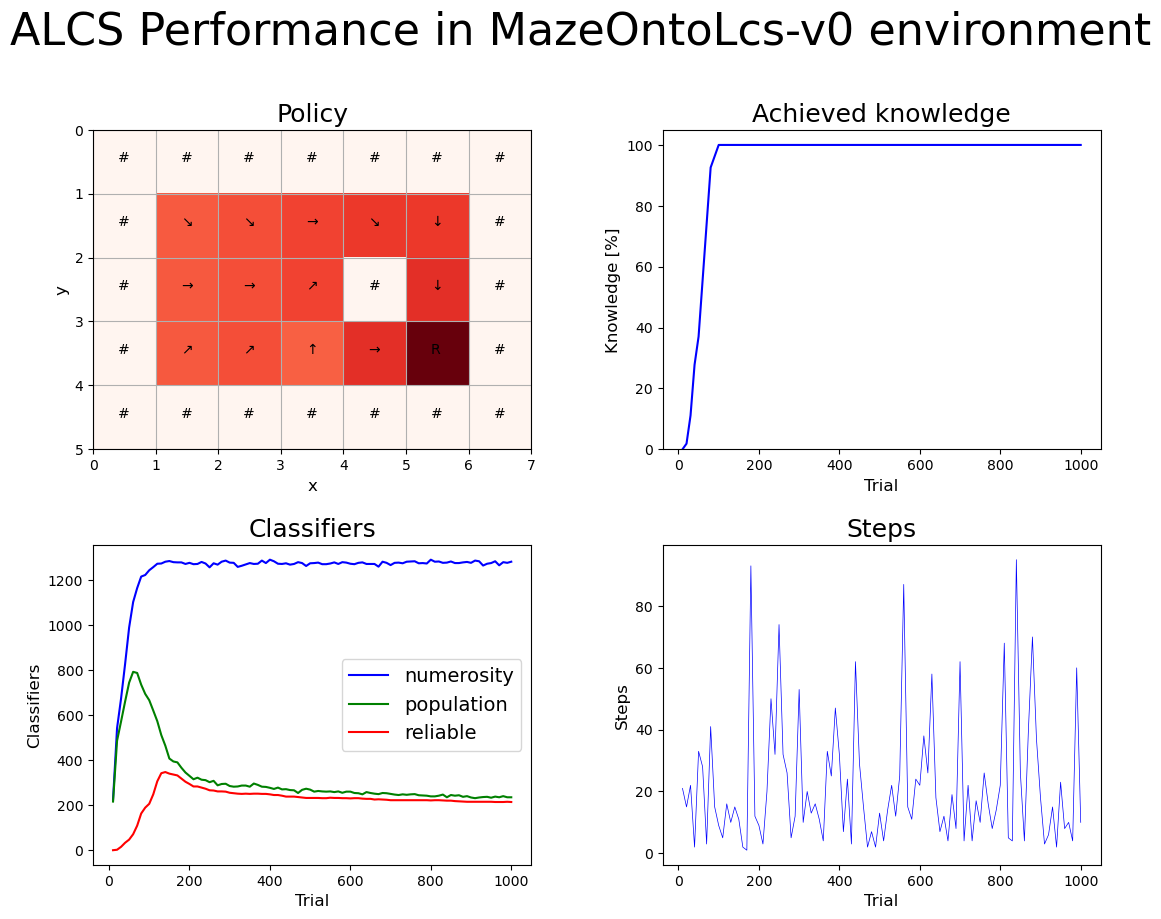

In [4]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, "MazeOntoLcs-v0", metrics_trial_frequency_explore, None)

In [5]:
print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ", _mean_reliable_classifier_specificity(population_explore, maze))

{'knowledge': 100.0, 'population': 164, 'numerosity': 1126, 'reliable': 143}
Mean reliable population specifity is  (0.36975524475524474, 0.36975524475524474, 1.0)


## Training of BEACS - Exploitation

In [6]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.2
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, 100)

CPU times: user 1.01 s, sys: 11.6 ms, total: 1.02 s
Wall time: 1.04 s


In [7]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, 100)

CPU times: user 921 ms, sys: 7.97 ms, total: 929 ms
Wall time: 939 ms


In [8]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=8,
    number_of_possible_actions=8,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=0.05,
    gamma=0.95,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, 100)

CPU times: user 902 ms, sys: 3.34 ms, total: 905 ms
Wall time: 907 ms


### Performance

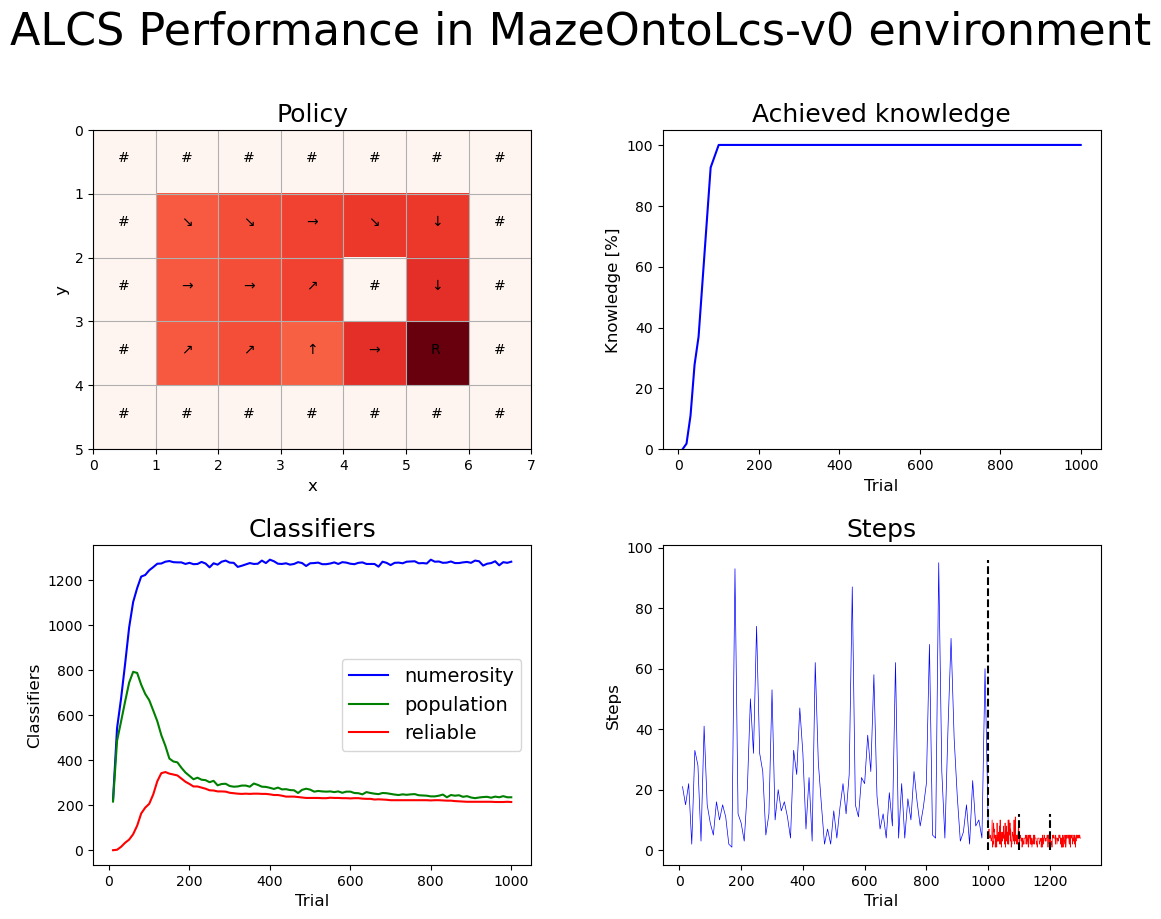

In [9]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += 100
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += 100 + 100
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, "MazeOntoLcs-v0", metrics_trial_frequency_explore, [100,100,100])

In [10]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= 1000 / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", 1000, " trials in exploration")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= 100
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", 100, " trials in first exploitation step")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= 100
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", 100, " trials in second exploitation step")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= 100
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", 100, " trials in last exploitation step")

print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  21.84  for a total of  1000  trials in exploration
Average number of steps to solve the maze is  4.65  for a total of  100  trials in first exploitation step
Average number of steps to solve the maze is  3.4  for a total of  100  trials in second exploitation step
Average number of steps to solve the maze is  3.76  for a total of  100  trials in last exploitation step
{'knowledge': 100.0, 'population': 164, 'numerosity': 1126, 'reliable': 143}


In [11]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl if cl.is_reliable()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

143


C:#####3## A:4 None E:(####1131:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 7.702e-08
exp: 641   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 23813 tbseq: 232   talp: 23823 tav: 38.93  



C:##9###0# A:2 None E:(011###31:1)
q: 1.0    ra: 999.7  rb: 999.8  ir: 1e+03  f: 999.8  err: 0.429 
exp: 184   num: 18 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 23801 tbseq: 12087 talp: 23801 tav: 63.51  



C:###01### A:3 None E:(0#119310:1)
q: 1.0    ra: 950.0  rb: 950.0  ir: 0.0    f: 950.0  err: 1.655e-06
exp: 812   num: 19 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 23666 tbseq: 915   talp: 23763 tav: 28.63  



C:##1##1## A:4 None E:(0###9310:1)
q: 1.0    ra: 950.0  rb: 950.0  ir: 0.0    f: 950.0  err: 0.007203
exp: 372   num: 